# **Import Library**

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
import joblib

# **Get and Preprocessed The Dataset**

In [96]:
df = pd.read_excel('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/dataset/data.xlsx')

unique_accords = set()
for accords_str in df['Main Accords']:
    accords = accords_str.split('\n')
    for accord in accords:
        if ':' in accord:
            unique_accords.add(accord.split(':')[0].strip())

# 2. Create new columns for each unique accord
df = df.assign(**{accord: 0.0 for accord in unique_accords}) 

# 3. Populate the accord columns with percentages
for index, row in df.iterrows():
    accords_str = row['Main Accords']
    accords = accords_str.split('\n')
    for accord in accords:
        if ':' in accord:
            accord_name = accord.split(':')[0].strip()
            percentage = float(accord.split(':')[1].strip().rstrip('%')) / 100
            df.loc[index, accord_name] = percentage

# 4. Remove the 'Main Accords' column (optional)
df = df.drop('Main Accords', axis=1) 
df

,URL,Perfume Name,Gender,Brand,Description,Description Blockquote,Top Notes,Middle Notes,Base Notes,Image,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
0,https://www.fragrantica.com/perfume/Zara/007-F...,007 Feels Like Summer Zara,for women,Zara,007 Feels Like Summer by Zara is a Aromatic Fr...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.60102.jpg,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,https://www.fragrantica.com/perfume/Tauer-Perf...,02 L'Air du Desert Marocain Tauer Perfumes,for women and men,Tauer Perfumes,02 L'Air du Desert Marocain by Tauer Perfumes ...,L`Air du Desert Marocain was made as a lighter...,"Coriander, Cumin, Petitgrain, Lavender","Labdanum, Birch, Jasmine, Geranium","Amber, Cedar, Vetiver, Patchouli, Oakmoss",https://fimgs.net/mdimg/perfume/375x500.4573.jpg,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.560906
2,https://www.fragrantica.com/perfume/Rabanne/1-...,1 Million Cologne Rabanne,for men,Rabanne,1 Million Cologne by Rabanne is a Woody Spicy...,In 2008 Paco Rabanne presented masculine fragr...,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.30497.jpg,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.476385,0.0,0.0,0.479111
3,https://www.fragrantica.com/perfume/Rabanne/1-...,1 Million Eau de Toilette Collector Edition Ra...,for men,Rabanne,1 Million Eau de Toilette Collector Edition by...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.47198.jpg,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.585230
4,https://www.fragrantica.com/perfume/Rabanne/1-...,1 Million Privé Rabanne,for men,Rabanne,1 Million Privé by Rabanne is a Oriental Woody...,Paco Rabanne launched 1 Million fragrance in 2...,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.37698.jpg,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20331,https://www.fragrantica.com/perfume/Rasasi/Yum...,Yumn Pour Homme Rasasi,for men,Rasasi,Yumn Pour Homme by Rasasi is a Oriental Woody ...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.92106.jpg,...,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.685000
20332,https://www.fragrantica.com/perfume/Lush/Yuzu-...,Yuzu and Cocoa Lush,for women and men,Lush,Yuzu and Cocoa by Lush is a Aromatic fragrance...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.60097.jpg,...,0.000000,0.0,0.0,0.000000,0.723684,0.0,0.000000,0.0,0.0,0.535790
20333,https://www.fragrantica.com/perfume/Lush/Zesty...,Zesty Lush,for women and men,Lush,Zesty by Lush is a fragrance for women and men...,"Zesty body spray is a fresh, fragrant burst of...",NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.93841.jpg,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.524512
20334,https://www.fragrantica.com/perfume/Rasasi/Zin...,Zinobia Rasasi,for women,Rasasi,Zinobia by Rasasi is a Oriental Floral fragran...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.19664.jpg,...,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


# **Feature Selection**

In [97]:
numerical_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
numerical_columns

Index(['Rating Value', 'Best Rating', 'Votes', 'tennis ball', 'aldehydic',
       'yellow floral', 'rum', 'vanilla', 'conifer', 'chocolate', 'mossy',
       'sweet', 'Pear', 'woody', 'lactonic', 'herbal', 'cherry', 'nutty',
       'whiskey', 'balsamic', 'terpenic', 'soft spicy', 'clay', 'aquatic',
       'wine', 'anis', 'alcohol', 'iris', 'bitter', 'smoky', 'coca-cola',
       'green', 'warm spicy', 'tropical', 'aromatic', 'brown scotch tape',
       'coconut', 'coffee', 'violet', 'animalic', 'soapy', 'sour', 'paper',
       'tuberose', 'almond', 'cannabis', 'tobacco', 'honey', 'fruity',
       'cinnamon', 'industrial glue', 'ozonic', 'marine', 'camphor', 'powdery',
       'earthy', 'rose', 'white floral', 'caramel', 'beeswax', 'patchouli',
       'vodka', 'musky', 'oud', 'leather', 'metallic', 'mineral', 'sake',
       'amber', 'asphault', 'rubber', 'oily', 'Champagne', 'sand', 'citrus',
       'floral', 'plastic', 'foresty', 'lavender', 'cacao', 'savory', 'fresh',
       'vinyl', 'sa

In [98]:
columns_to_exclude = ['Rating Value', 'Best Rating', 'Votes']
features = numerical_columns.drop(columns_to_exclude)
features

Index(['tennis ball', 'aldehydic', 'yellow floral', 'rum', 'vanilla',
       'conifer', 'chocolate', 'mossy', 'sweet', 'Pear', 'woody', 'lactonic',
       'herbal', 'cherry', 'nutty', 'whiskey', 'balsamic', 'terpenic',
       'soft spicy', 'clay', 'aquatic', 'wine', 'anis', 'alcohol', 'iris',
       'bitter', 'smoky', 'coca-cola', 'green', 'warm spicy', 'tropical',
       'aromatic', 'brown scotch tape', 'coconut', 'coffee', 'violet',
       'animalic', 'soapy', 'sour', 'paper', 'tuberose', 'almond', 'cannabis',
       'tobacco', 'honey', 'fruity', 'cinnamon', 'industrial glue', 'ozonic',
       'marine', 'camphor', 'powdery', 'earthy', 'rose', 'white floral',
       'caramel', 'beeswax', 'patchouli', 'vodka', 'musky', 'oud', 'leather',
       'metallic', 'mineral', 'sake', 'amber', 'asphault', 'rubber', 'oily',
       'Champagne', 'sand', 'citrus', 'floral', 'plastic', 'foresty',
       'lavender', 'cacao', 'savory', 'fresh', 'vinyl', 'salty',
       'fresh spicy'],
      dtype='objec

# **Build Autoecoder Model**

In [99]:
# Encoder
encoder_input = layers.Input(shape=(len(features),))
encoder = layers.Dense(128, activation='relu')(encoder_input)
encoder = layers.Dense(64, activation='relu')(encoder)
encoder_output = layers.Dense(32, activation='relu')(encoder)

# Decoder
decoder = layers.Dense(64, activation='relu')(encoder_output)
decoder = layers.Dense(128, activation='relu')(decoder)
decoder_output = layers.Dense(len(features), activation='sigmoid')(decoder)

# Autoencoder Model
autoencoder = models.Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [100]:
n_splits = 10 

# K-Fold Cross-Validation
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
X = df[features].values

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    min_delta=0.0001
)

# **Extract Features and Iterate through the folds**

Fold 1: Training MSE = 0.0011, Validation MSE = 0.0013
Fold 2: Training MSE = 0.0011, Validation MSE = 0.0011
Fold 3: Training MSE = 0.0011, Validation MSE = 0.0011
Fold 4: Training MSE = 0.0011, Validation MSE = 0.0011
Fold 5: Training MSE = 0.0011, Validation MSE = 0.0011
Fold 6: Training MSE = 0.0010, Validation MSE = 0.0010
Fold 7: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 8: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 9: Training MSE = 0.0009, Validation MSE = 0.0010
Fold 10: Training MSE = 0.0009, Validation MSE = 0.0009


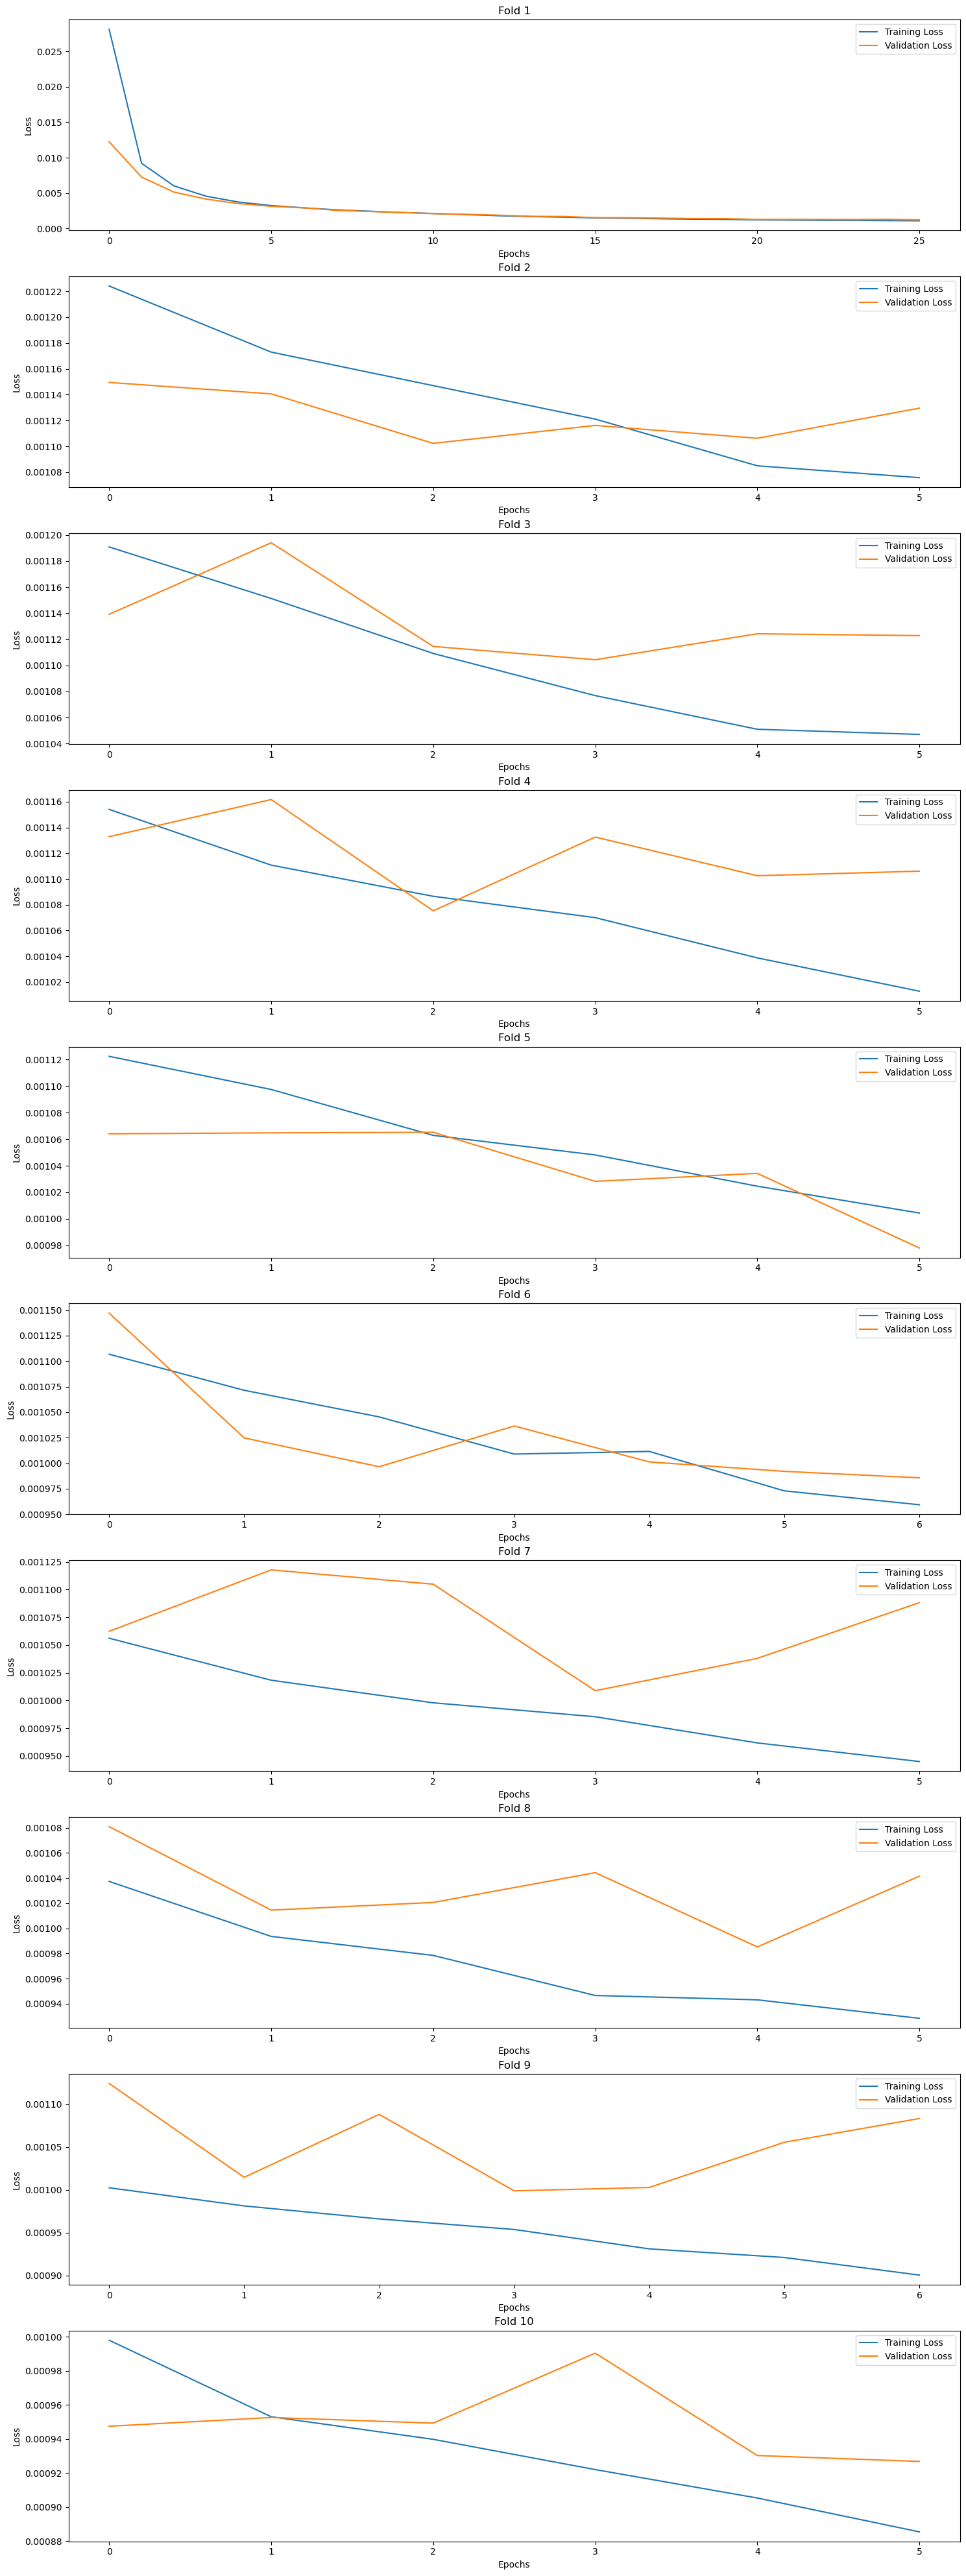


Training and validation loss telah disimpan di training_kfold_results.png


In [101]:
# List untuk menyimpan hasil
scalers = []
training_losses = []
validation_losses = []

# Membuat subplot sesuai jumlah fold
fig, axes = plt.subplots(n_splits, 1, figsize=(15, 4 * n_splits))
fig.tight_layout(pad=3.0)

# Jika hanya ada 1 fold, ubah menjadi list untuk konsistensi
if n_splits == 1:
    axes = [axes]

# Training dan evaluasi untuk setiap fold
for fold_idx, (train_index, val_index) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    
    # Normalisasi data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    scalers.append(scaler)
    
    # Melatih model
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, X_val_scaled),
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Menyimpan riwayat loss untuk plotting
    axes[fold_idx].plot(history.history['loss'], label='Training Loss')
    axes[fold_idx].plot(history.history['val_loss'], label='Validation Loss')
    axes[fold_idx].set_title(f"Fold {fold_idx + 1}")
    axes[fold_idx].set_xlabel('Epochs')
    axes[fold_idx].set_ylabel('Loss')
    axes[fold_idx].legend()
    
    # Evaluasi data training
    train_loss = autoencoder.evaluate(X_train_scaled, X_train_scaled, verbose=0)
    training_losses.append(train_loss)
    
    # Evaluasi data validasi
    val_loss = autoencoder.evaluate(X_val_scaled, X_val_scaled, verbose=0)
    validation_losses.append(val_loss)
    
    print(f'Fold {fold_idx + 1}: Training MSE = {train_loss:.4f}, Validation MSE = {val_loss:.4f}')

# Menampilkan plot
plt.show()

# Menyimpan plot ke file
fig.savefig("training_kfold_results.png", dpi=300, bbox_inches='tight')
print("\nTraining and validation loss telah disimpan di training_kfold_results.png")

In [102]:
# Generate encodings after scaling
X_scaled = np.zeros_like(X, dtype=np.float64)

for fold_idx, (train_index, val_index) in enumerate(kfold.split(X)):
    X_fold = X[val_index]
    scaler = scalers[fold_idx]
    X_scaled[val_index] = scaler.transform(X_fold)

perfume_encodings = autoencoder.predict(X_scaled) 

636/636 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [103]:
df[features]

,tennis ball,aldehydic,yellow floral,rum,vanilla,conifer,chocolate,mossy,sweet,Pear,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.658751,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.560906
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.476385,0.0,0.0,0.479111
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.585230
4,0.0,0.0,0.0,0.0,0.564821,0.000000,0.0,0.0,0.772275,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20331,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.685000
20332,0.0,0.0,0.0,0.0,0.493422,0.000000,0.0,0.0,0.611317,0.0,...,0.000000,0.0,0.0,0.000000,0.723684,0.0,0.000000,0.0,0.0,0.535790
20333,0.0,0.0,0.0,0.0,0.000000,0.479269,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.524512
20334,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [104]:
# Simpan autoencoder
autoencoder.save('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/autoencoder_model.h5')

# Simpan scaler dari fold tertentu, misalnya fold 0
joblib.dump(scalers[0], 'D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/scaler.pkl')


['D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/scaler.pkl']

# **Compute Similarity**

In [105]:
# Recommendation function
def recommend_perfumes(input_encoding):
    similarities = cosine_similarity(input_encoding, perfume_encodings)

    recommendations_df = pd.DataFrame({
        'Similarity Score': similarities[0]
    })
    
    # Concatenate the similarity scores with the original DataFrame
    recommendations_df = pd.concat([recommendations_df, df.reset_index()], axis=1) 
    return recommendations_df.sort_values(by='Similarity Score', ascending=False)

# **Get Recommendations**

In [106]:
# Load autoencoder dan encoder
autoencoder = load_model('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/autoencoder_model.h5')
scaler = joblib.load('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/scaler.pkl')

perfume_encodings = autoencoder.predict(X_scaled)
perfume_encodings

636/636 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[2.05185115e-05, 2.53898255e-03, 7.31476536e-03, ...,
        7.24832498e-05, 1.95795018e-03, 1.36009490e-04],
       [3.37273777e-05, 3.03433696e-03, 1.78038352e-03, ...,
        6.93392285e-05, 1.13316521e-03, 5.74430943e-01],
       [2.07430130e-05, 3.39613631e-02, 9.60475372e-05, ...,
        3.40914958e-05, 4.18080240e-02, 3.81334096e-01],
       ...,
       [8.96173660e-05, 1.89478335e-03, 1.21639852e-04, ...,
        1.56479364e-05, 2.76845507e-03, 3.98133218e-01],
       [4.97802193e-06, 3.26257804e-03, 2.19728961e-03, ...,
        5.40745750e-05, 4.81682306e-04, 1.18643185e-02],
       [9.74902196e-06, 2.27147434e-03, 1.01431098e-03, ...,
        2.23592724e-05, 5.09899110e-04, 7.77583838e-01]], dtype=float32)

In [122]:
# Test the function and encodings
query_perfume_index = 15704
recommendations = recommend_perfumes(perfume_encodings[query_perfume_index].reshape(1, -1))
print(f"Encoding for perfume at index {query_perfume_index}:\n{perfume_encodings[query_perfume_index]}")
print("\nTop 10 recommendations:")
recommendations.head(10)

Encoding for perfume at index 15704:
[1.00395782e-05 2.53295293e-03 5.19063463e-03 3.28853464e-04
 1.19735412e-02 2.65337556e-04 7.09840879e-06 7.77569308e-04
 6.90629985e-03 7.29654289e-07 4.83806664e-03 1.21464776e-02
 4.49776504e-04 5.57932799e-05 6.85113191e-04 4.50411644e-05
 1.79433955e-05 1.21095309e-06 3.14188143e-03 1.92248149e-06
 4.34361900e-05 7.83314114e-04 3.37113801e-04 3.84459463e-06
 1.27515325e-03 5.53864666e-05 6.47836277e-05 6.92221533e-07
 3.80095234e-03 6.59557059e-03 1.82204982e-04 1.21363769e-06
 6.09708695e-06 1.42829819e-03 5.55358711e-04 1.21606005e-04
 2.26860047e-05 1.01217767e-03 7.40522239e-08 1.84399541e-05
 9.97301104e-05 7.53334956e-04 4.14878770e-07 6.50295755e-04
 5.76457591e-04 1.18591229e-03 1.68953557e-05 7.46098522e-05
 1.35173544e-03 1.25123945e-03 1.98646754e-04 9.28364787e-03
 2.05654828e-06 9.71793270e-05 5.13019180e-03 5.07713761e-04
 9.23065003e-04 2.11720369e-04 9.50840260e-08 1.41632813e-06
 5.61421504e-03 1.06910129e-05 1.11130753e-03 1.

,Similarity Score,index,URL,Perfume Name,Gender,Brand,Description,Description Blockquote,Top Notes,Middle Notes,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
3433,1.0,3433,https://www.fragrantica.com/perfume/Zara/Black...,Black Dart Zara,for women and men,Zara,Black Dart by Zara is a Chypre Floral fragranc...,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12995,1.0,12995,https://www.fragrantica.com/perfume/Revlon/Cha...,Charlie Naturals Fresh Flowers Revlon,for women,Revlon,Charlie Naturals Fresh Flowers by Revlon is a ...,The collection includes: Charlie Naturals Herb...,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11099,1.0,11099,https://www.fragrantica.com/perfume/Avon/Topsy...,Topsy Avon,for women,Avon,Topsy by Avon is a Floral fragrance for women....,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13291,1.0,13291,https://www.fragrantica.com/perfume/Jequiti/Co...,Com Todo Amor e Carinho Jequiti,for women,Jequiti,Com Todo Amor e Carinho by Jequiti is a Floral...,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13428,1.0,13428,https://www.fragrantica.com/perfume/Jequiti/Co...,Corais Floral Jequiti,for women,Jequiti,Corais Floral by Jequiti is a Floral fragrance...,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14666,1.0,14666,https://www.fragrantica.com/perfume/Coach/Free...,Freesia Splash Coach,for women,Coach,Freesia Splash by Coach is a Floral fragrance ...,The house of Coach has presented three summer ...,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14665,1.0,14665,https://www.fragrantica.com/perfume/Caswell-Ma...,Freesia Signature Scent Caswell Massey,for women,Caswell Massey,Freesia Signature Scent by Caswell Massey is a...,Caswell-Massey's Freesia Signature Scent is a ...,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10694,1.0,10694,https://www.fragrantica.com/perfume/O-Boticari...,Sophie Disney 100 Anos Mulan O Boticário,for women,O Boticário,Sophie Disney 100 Anos Mulan by O Boticário is...,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5785,1.0,5785,https://www.fragrantica.com/perfume/Victoria-s...,Aqua Kiss Unwrapped Victoria's Secret,for women,Victoria's Secret,Aqua Kiss Unwrapped by Victoria's Secret is a ...,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10497,1.0,10497,https://www.fragrantica.com/perfume/Victoria-s...,Secret Escape Sheer Freesia & Guava Flowers Vi...,for women,Victoria's Secret,Secret Escape Sheer Freesia & Guava Flowers by...,A refreshing fragrance body mist infused with ...,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


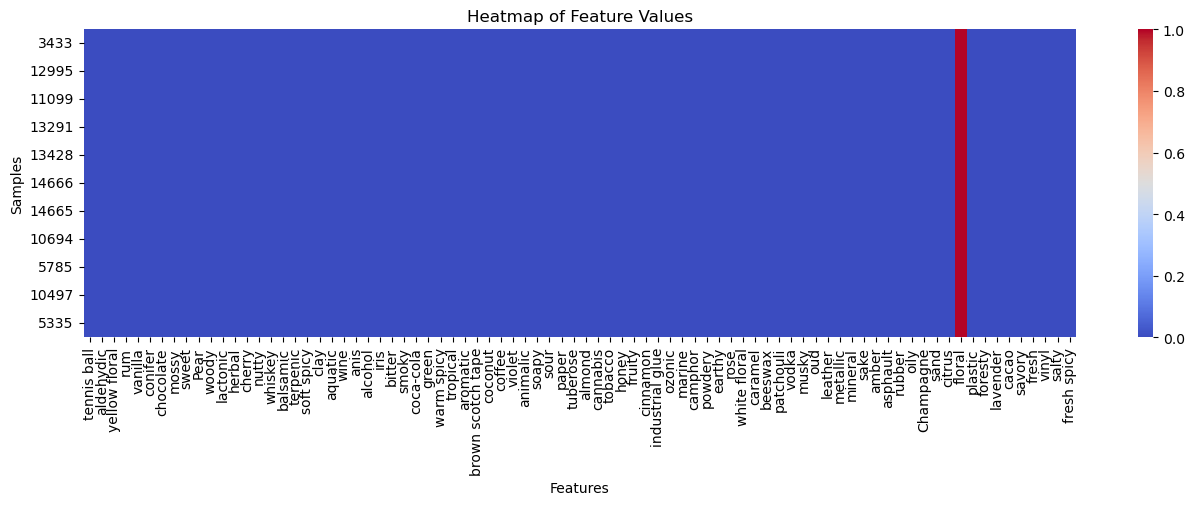

In [123]:
data_for_heatmap = recommendations[features].head(11)

plt.figure(figsize=(16, 4))
sns.heatmap(
    data_for_heatmap,
    cmap="coolwarm",     
    annot=False,          
    cbar=True,             
    xticklabels=True,     
    yticklabels=True     
)

plt.title("Heatmap of Feature Values")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

In [124]:
recommendations[features]

,tennis ball,aldehydic,yellow floral,rum,vanilla,conifer,chocolate,mossy,sweet,Pear,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
3433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
row = df.iloc[7193]
print(", ".join(row[features].astype(str)))

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64999919500072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85999935600058, 0.0, 0.0, 0.0


In [139]:
# Test the function and encodings
query_perfume_index = 15704
recommendations = recommend_perfumes(np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64999919500072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85999935600058, 0.0, 0.0, 0.0]).reshape(1, -1))
print(f"Encoding for perfume at index {query_perfume_index}:\n{perfume_encodings[query_perfume_index]}")
print("\nTop 10 recommendations:")
recommendations.head(10)

Encoding for perfume at index 15704:
[1.00395782e-05 2.53295293e-03 5.19063463e-03 3.28853464e-04
 1.19735412e-02 2.65337556e-04 7.09840879e-06 7.77569308e-04
 6.90629985e-03 7.29654289e-07 4.83806664e-03 1.21464776e-02
 4.49776504e-04 5.57932799e-05 6.85113191e-04 4.50411644e-05
 1.79433955e-05 1.21095309e-06 3.14188143e-03 1.92248149e-06
 4.34361900e-05 7.83314114e-04 3.37113801e-04 3.84459463e-06
 1.27515325e-03 5.53864666e-05 6.47836277e-05 6.92221533e-07
 3.80095234e-03 6.59557059e-03 1.82204982e-04 1.21363769e-06
 6.09708695e-06 1.42829819e-03 5.55358711e-04 1.21606005e-04
 2.26860047e-05 1.01217767e-03 7.40522239e-08 1.84399541e-05
 9.97301104e-05 7.53334956e-04 4.14878770e-07 6.50295755e-04
 5.76457591e-04 1.18591229e-03 1.68953557e-05 7.46098522e-05
 1.35173544e-03 1.25123945e-03 1.98646754e-04 9.28364787e-03
 2.05654828e-06 9.71793270e-05 5.13019180e-03 5.07713761e-04
 9.23065003e-04 2.11720369e-04 9.50840260e-08 1.41632813e-06
 5.61421504e-03 1.06910129e-05 1.11130753e-03 1.

,Similarity Score,index,URL,Perfume Name,Gender,Brand,Description,Description Blockquote,Top Notes,Middle Notes,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
7193,0.998999,7193,https://www.fragrantica.com/perfume/Avon/Eau-d...,Eau de Bouquet Bienestar Peonías Blancas Avon,for women,Avon,Eau de Bouquet Bienestar Peonías Blancas by Av...,NaN,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.859999,0.0,0.0,0.0
9843,0.998999,9843,https://www.fragrantica.com/perfume/Victoria-s...,Passion Flowers Victoria's Secret,for women,Victoria's Secret,Passion Flowers by Victoria's Secret is a Flor...,NaN,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.859999,0.0,0.0,0.0
17141,0.998999,17141,https://www.fragrantica.com/perfume/Coach/Peon...,Peony Splash Coach,for women,Coach,Peony Splash by Coach is a Floral fragrance fo...,The house of Coach has presented three summer ...,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.859999,0.0,0.0,0.0
9881,0.998999,9881,https://www.fragrantica.com/perfume/Avon/Peony...,Peony Avon,for women,Avon,Peony by Avon is a fragrance for women. Peony ...,NaN,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.859999,0.0,0.0,0.0
16092,0.993704,16092,https://www.fragrantica.com/perfume/Nina-Ricci...,Love in Paris Christmas 2006 Nina Ricci,for women,Nina Ricci,Love in Paris Christmas 2006 by Nina Ricci is ...,NaN,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.809091,0.0,0.0,0.0
18317,0.986792,18317,https://www.fragrantica.com/perfume/Kate-Spade...,TRULYdaring Kate Spade,for women,Kate Spade,TRULYdaring by Kate Spade is a Floral fragranc...,"""Inspired by the unapologetically feminine col...",NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.673230,0.0,0.0,0.0
5395,0.975163,5395,https://www.fragrantica.com/perfume/Zara/Zara-...,Zara Rose Eau de Toilette Zara,for women,Zara,Zara Rose Eau de Toilette by Zara is a Floral ...,NaN,Black,Peony,...,0.950588,0.0,0.0,0.0,0.0,0.0,0.695294,0.0,0.0,0.0
4597,0.973247,4597,https://www.fragrantica.com/perfume/Zara/Nude-...,Nude Bouquet Zara,for women,Zara,Nude Bouquet by Zara is a fragrance for women....,Eau de parfum. The fragrance pyramid reveals n...,Cherry,Peony,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.860000,0.0,0.0,0.0
10455,0.972906,10455,https://www.fragrantica.com/perfume/Avon/Scent...,Scent Essence - Romantic Bouquet Avon,for women,Avon,Scent Essence - Romantic Bouquet by Avon is a ...,NaN,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.593936,0.0,0.0,0.0
16331,0.969115,16331,https://www.fragrantica.com/perfume/Jequiti/Ma...,Maria Manhã Radiante Jequiti,for women,Jequiti,Maria Manhã Radiante by Jequiti is a Floral fr...,NaN,NaN,NaN,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.543478,0.0,0.0,0.0


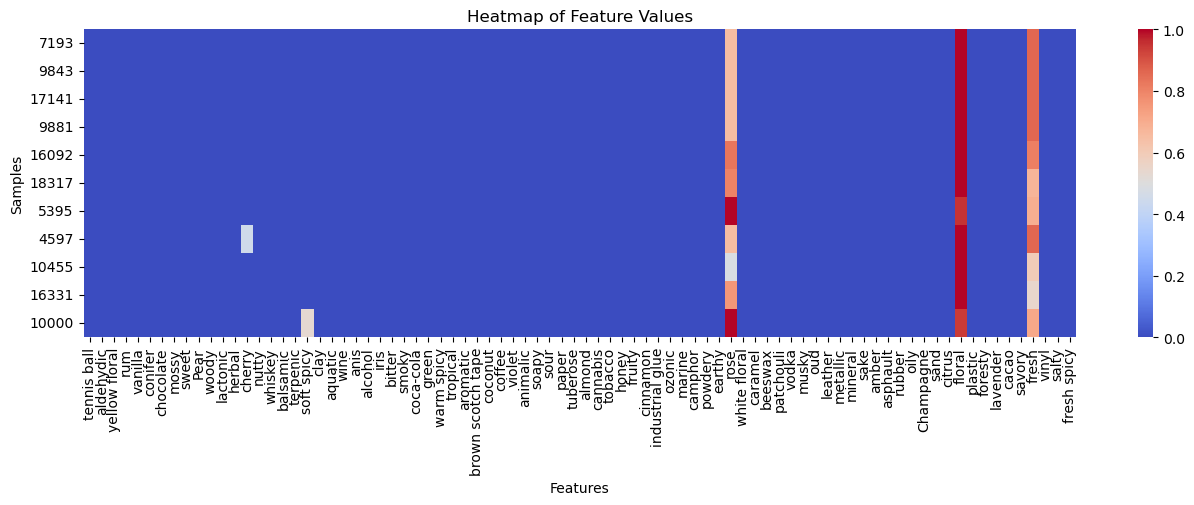

In [141]:
data_for_heatmap = recommendations[features].head(11)

plt.figure(figsize=(16, 4))
sns.heatmap(
    data_for_heatmap,
    cmap="coolwarm",     
    annot=False,          
    cbar=True,             
    xticklabels=True,     
    yticklabels=True     
)

plt.title("Heatmap of Feature Values")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

In [144]:
recommendations[features].head(10).to_csv("hasil_print.csv")

# **Save The Model**

In [110]:
# Save encodings
np.save('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/model_encodings.npy', perfume_encodings)

# Load encodings
perfume_encodings = np.load('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/model_encodings.npy')

# **Finding Relevant Index**

In [111]:
df_recommendation = recommendations.head(30)

In [112]:
row = df.iloc[query_perfume_index]
input = np.array(row[features])
input_df = pd.DataFrame([input], columns=recommendations[features].columns)
input_df

,tennis ball,aldehydic,yellow floral,rum,vanilla,conifer,chocolate,mossy,sweet,Pear,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
df_recommendation[features]

,tennis ball,aldehydic,yellow floral,rum,vanilla,conifer,chocolate,mossy,sweet,Pear,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
18473,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1665,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1046,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6057,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
18459,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
18457,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
18490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
15186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
18483,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [114]:
df_features_subtracted = df_recommendation[features].sub(input_df.iloc[0], axis=1).abs()
df_features_subtracted.insert(0, 'Total', df_features_subtracted.sum(axis=1))
df_features_subtracted = df_features_subtracted.sort_values(by='Total', ascending=True)
df_features_subtracted

,Total,tennis ball,aldehydic,yellow floral,rum,vanilla,conifer,chocolate,mossy,sweet,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
18473,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1046,0.004787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1665,0.004788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6057,0.098121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2957,0.444788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1251,0.444788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5667,0.444788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
19240,0.444788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
18472,0.444788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
19241,0.444788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [115]:
index_list = df_features_subtracted.index.to_list()
df_selected_rows = df.iloc[index_list]
df_selected_rows

,URL,Perfume Name,Gender,Brand,Description,Description Blockquote,Top Notes,Middle Notes,Base Notes,Image,...,floral,plastic,foresty,lavender,cacao,savory,fresh,vinyl,salty,fresh spicy
18473,https://www.fragrantica.com/perfume/Molinard/V...,Vanille Molinard,for women,Molinard,Vanille by Molinard is a Oriental Vanilla frag...,In March 2015 the house of Molinard launches t...,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.30430.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1046,https://www.fragrantica.com/perfume/Victoria-s...,Midnight Fleur Victoria's Secret,for women,Victoria's Secret,Midnight Fleur by Victoria's Secret is a Orien...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.65625.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1665,https://www.fragrantica.com/perfume/Victoria-s...,Warm & Cozy Victoria's Secret,for women,Victoria's Secret,Warm & Cozy by Victoria's Secret is a Oriental...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.63113.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6057,https://www.fragrantica.com/perfume/Victoria-s...,Bare Vanilla Shimmer Victoria's Secret,for women and men,Victoria's Secret,Bare Vanilla Shimmer by Victoria's Secret is a...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.89093.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2957,https://www.fragrantica.com/perfume/Guerlain/S...,Shalimar Millésime Vanilla Planifolia Guerlain,for women,Guerlain,Shalimar Millésime Vanilla Planifolia by Guerl...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.69424.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1251,https://www.fragrantica.com/perfume/Victoria-s...,Pink Vanilla Victoria's Secret,for women,Victoria's Secret,Pink Vanilla by Victoria's Secret is a Orienta...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.89198.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5667,https://www.fragrantica.com/perfume/Bvlgari/Al...,Allegra Magnifying Vanilla Essence Bvlgari,for women,Bvlgari,Allegra Magnifying Vanilla Essence by Bvlgari ...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.64745.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
19240,https://www.fragrantica.com/perfume/Lush/Cream...,Creamy Candy Lush,for women and men,Lush,Creamy Candy by Lush is a Oriental Vanilla fra...,Creamy Candy is a limited edition perfume that...,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.22220.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
18472,https://www.fragrantica.com/perfume/Adopt-Parf...,Vanille Adopt Parfums,for women,Adopt Parfums,Vanille by Adopt Parfums is a Oriental Vanilla...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.23445.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
19241,https://www.fragrantica.com/perfume/Lush/Cream...,Creamy Candy Lush,for women and men,Lush,Creamy Candy by Lush is a Oriental Vanilla fra...,NaN,NaN,NaN,NaN,https://fimgs.net/mdimg/perfume/375x500.88994.jpg,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [116]:
df_selected_rows.index.to_list

<bound method IndexOpsMixin.tolist of Int64Index([18473,  1046,  1665,  6057,  2957,  1251,  5667, 19240, 18472,
            19241, 15186, 18490, 18457, 18459, 18483, 14304,  6954, 10614,
             6621, 16960,   250, 18475, 10358,  6421,   251,  7213,  8077,
            14334,  1398, 11797],
           dtype='int64')>

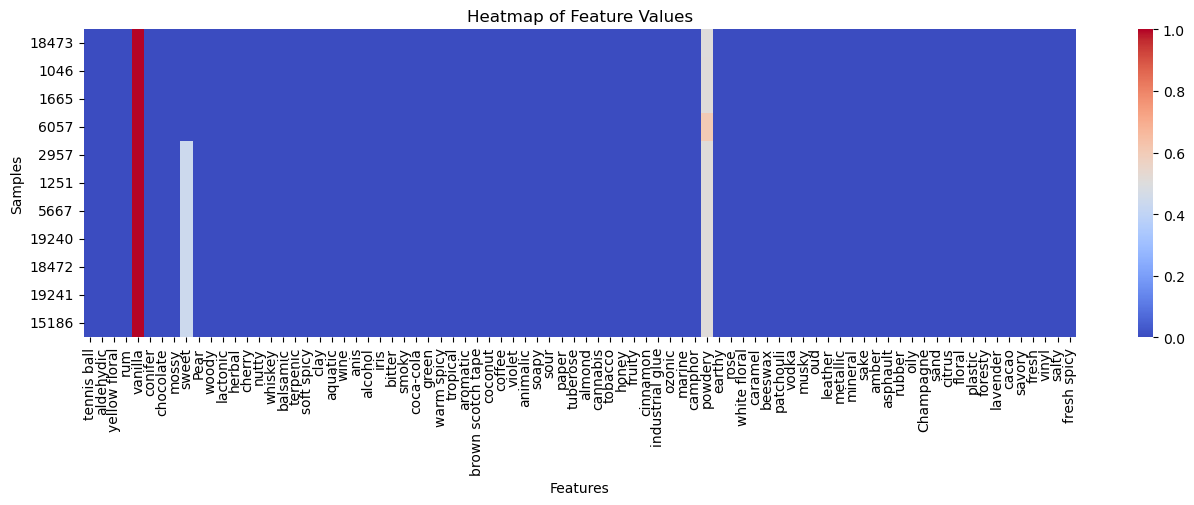

In [117]:
data_for_heatmap = df_selected_rows[features].head(11)

plt.figure(figsize=(16, 4))
sns.heatmap(
    data_for_heatmap,
    cmap="coolwarm",     
    annot=False,          
    cbar=True,             
    xticklabels=True,     
    yticklabels=True     
)

plt.title("Heatmap of Feature Values")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

# **Evaluate Result**

In [118]:
# --- Evaluation Metrics ---
def precision_at_k(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    
    true_positives = sum(1 for p in predicted if p in actual)
    return true_positives / min(len(predicted), k)

def average_precision(actual, predicted, k=10):
    if not actual:
        return 0.0
    
    precision_values = []
    num_rel = 0
    for i, p in enumerate(predicted):
      if i >= k:
        break
      if p in actual:
        num_rel += 1
        precision_values.append(num_rel / (i + 1))
    
    if not precision_values:
        return 0.0
    return sum(precision_values) / min(len(actual), k)

def reciprocal_rank(actual, predicted, k=10):
    for i, item in enumerate(predicted):
        if i >= k:
            break
        if item in actual:
            return 1 / (i + 1)
    return 0.0

# Calculate Mean metrics
def calculate_mean_metrics(perfume_encodings, df, relevant_docs, k=10):
    mean_precision = 0.0
    mean_ap = 0.0
    mean_rr = 0.0
    num_queries = len(relevant_docs)
    
    for query_id, relevant_items in relevant_docs.items():
        if query_id >= len(perfume_encodings):
            continue  
            
        query_encoding = perfume_encodings[query_id].reshape(1, -1)
        recommendations = recommend_perfumes(query_encoding)
        recommended_items = recommendations['index'].tolist()

        # Calculate metrics for this query
        prec_k = precision_at_k(relevant_items, recommended_items, k)
        avg_prec = average_precision(relevant_items, recommended_items, k)
        recip_rank = reciprocal_rank(relevant_items, recommended_items, k)

        mean_precision += prec_k
        mean_ap += avg_prec
        mean_rr += recip_rank
        
        print(f"Query ID: {query_id}")
        print(f"  Precision@{k}: {prec_k:.4f}")
        print(f"  Average Precision: {avg_prec:.4f}")
        print(f"  Reciprocal Rank: {recip_rank:.4f}")

    if num_queries == 0:
      return 0.0, 0.0, 0.0
    return mean_precision/num_queries, mean_ap/num_queries, mean_rr/num_queries


In [119]:
relevant_docs = {
    10:[10, 7522, 20135, 196, 10059, 15392, 10113, 17137, 6456, 7417],
    1143:[247,101,248], 
    100:[1143, 15695,3962,7298, 4678]
}
# Evaluate the model and print the results
mean_precision, mean_ap, mean_rr = calculate_mean_metrics(perfume_encodings, df, relevant_docs, k=10)
print("\n------------------------------------------\n")
print(f"Mean Precision@10: {mean_precision:.4f}")
print(f"Mean Average Precision (MAP): {mean_ap:.4f}")
print(f"Mean Reciprocal Rank (MRR): {mean_rr:.4f}")

Query ID: 10
  Precision@10: 0.7000
  Average Precision: 0.6778
  Reciprocal Rank: 1.0000
Query ID: 1143
  Precision@10: 0.0000
  Average Precision: 0.0000
  Reciprocal Rank: 0.0000
Query ID: 100
  Precision@10: 0.0000
  Average Precision: 0.0000
  Reciprocal Rank: 0.0000

------------------------------------------

Mean Precision@10: 0.2333
Mean Average Precision (MAP): 0.2259
Mean Reciprocal Rank (MRR): 0.3333


# **Create Customizable Notes Percentage**

In [120]:
# --- GUI Part ---
root = tk.Tk()
root.title("Features Table with Sliders")

frame = tk.Frame(root)
frame.pack(fill=tk.BOTH, expand=True)

canvas = tk.Canvas(frame)
scrollbar = ttk.Scrollbar(frame, orient=tk.VERTICAL, command=canvas.yview)
scrollable_frame = ttk.Frame(canvas)

scrollable_frame.bind(
    "<Configure>",
    lambda e: canvas.configure(scrollregion=canvas.bbox("all"))
)

canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
canvas.configure(yscrollcommand=scrollbar.set)

# Tempatkan scrollbar dan canvas
canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# Daftar untuk menyimpan slider
sliders = []

# Tambahkan data ke tabel
for i, feature in enumerate(features):
    # Label untuk kolom pertama
    label = tk.Label(scrollable_frame, text=feature, anchor="w", width=10)
    label.grid(row=i, column=0, padx=0, pady=0, sticky="w")

    # Slider untuk kolom kedua
    slider = tk.Scale(scrollable_frame, from_=0, to=100, orient=tk.HORIZONTAL, length=200)
    slider.grid(row=i, column=1, padx=0, pady=0)
    sliders.append(slider)

# Fungsi untuk mengambil nilai slider
def get_slider_values():
    slider_values = {}
    for i, slider in enumerate(sliders):
        slider_values[features[i]] = slider.get()

    # Konversi nilai slider ke NumPy array
    input_array = np.array([slider_values[feature] for feature in features], dtype=float)

    # Normalisasi jika diperlukan (contoh: rentang slider 0-100 ke 0-1)
    input_array = input_array / 100

    # Transformasi dengan scaler (gunakan scaler dari fold 0)
    input_scaled = scalers[0].transform([input_array])

    # Dapatkan encoding dari model encoder
    input_encoding = autoencoder.predict(input_scaled)

    # Hitung similarity dan tampilkan rekomendasi
    recommendations = recommend_perfumes(input_encoding)

    # # Tampilkan 10 rekomendasi teratas
    print(recommendations['URL'].head(10).to_list())
    print(recommendations.index[:10].tolist())


    data_for_heatmap = recommendations[features].head(11)

    plt.figure(figsize=(16, 4))
    sns.heatmap(
        data_for_heatmap,
        cmap="coolwarm",
        annot=False,
        cbar=True,
        xticklabels=True,
        yticklabels=True
    )

    plt.title("Heatmap of Feature Values")
    plt.xlabel("Features")
    plt.ylabel("Samples")
    plt.show()


# Tombol untuk menampilkan nilai slider
btn = tk.Button(root, text="Get Recommendations", command=get_slider_values)
btn.pack(pady=10)

root.mainloop()

# **Save Model**

In [121]:
# Simpan autoencoder
autoencoder.save('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/autoencoder_model.h5')

# Simpan encoder
encoder_model.save('D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/encoder_model.h5')


NameError: name 'encoder_model' is not defined

In [ ]:
import joblib


# Simpan scaler dari fold tertentu, misalnya fold 0
joblib.dump(scalers[0], 'D:/KULIAH/Tugas-Tugas Kuliah Semester 7/Tugas Akhir/autoencoder/scaler.pkl')
